## 作業目標
* 嘗試比較用 color histogram 和 HOG 特徵來訓練的 SVM 分類器在 cifar10 training 和 testing data 上準確度的差別

In [1]:
import os
import keras
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

import numpy as np
import cv2 # 載入 cv2 套件
import matplotlib.pyplot as plt

train, test = keras.datasets.cifar10.load_data()

Using TensorFlow backend.


In [2]:
x_train, y_train = train
x_test, y_test = test
y_train = y_train.astype(int)
y_test = y_test.astype(int)

#### 產生直方圖特徵的訓練資料

In [3]:
x_train_histogram = []
x_test_histogram = []

# 對於所有訓練資料
for i in range(len(x_train)):
    chans = cv2.split(x_train[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())
    # 把計算的直方圖特徵收集起來
    x_train_histogram.append(hist_feature)

# 對於所有測試資料也做一樣的處理
for i in range(len(x_test)):
    chans = cv2.split(x_test[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())
    x_test_histogram.append(hist_feature)

x_train_histogram = np.array(x_train_histogram)
x_test_histogram = np.array(x_test_histogram)


#### 產生 HOG 特徵的訓練資料
* HOG 特徵通過計算和統計圖像局部區域的梯度方向直方圖來構建特徵，具體細節不在我們涵蓋的範圍裡面，有興趣的同學請參考[補充資料](https://www.cnblogs.com/zyly/p/9651261.html)哦

In [4]:
# SZ=20
bin_n = 16 # Number of bins

def hog(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist.astype(np.float32)

x_train_hog = np.array([hog(x) for x in x_train])
x_test_hog = np.array([hog(x) for x in x_test])

#### SVM model
* SVM 是機器學習中一個經典的分類算法，具體細節有興趣可以參考 [該知乎上的解釋](https://www.zhihu.com/question/21094489)，我們這裡直接調用 opencv 中實現好的函數

#### 用 histogram 特徵訓練 SVM 模型
* 訓練過程可能會花點時間，請等他一下

In [5]:
SVM_hist = cv2.ml.SVM_create()
SVM_hist.setKernel(cv2.ml.SVM_LINEAR)
SVM_hist.setGamma(5.383)
SVM_hist.setType(cv2.ml.SVM_C_SVC)
SVM_hist.setC(2.67)

#training
SVM_hist.train(x_train_histogram, cv2.ml.ROW_SAMPLE, y_train)

# prediction
_, y_hist_train = SVM_hist.predict(x_train_histogram)
_, y_hist_test = SVM_hist.predict(x_test_histogram)

#### 用 HOG 特徵訓練 SVM 模型
* 訓練過程可能會花點時間，請等他一下

In [6]:
SVM_hog = cv2.ml.SVM_create()
SVM_hog.setKernel(cv2.ml.SVM_LINEAR)
SVM_hog.setGamma(5.383)
SVM_hog.setType(cv2.ml.SVM_C_SVC)
SVM_hog.setC(2.67)

#training
SVM_hog.train(x_train_hog, cv2.ml.ROW_SAMPLE, y_train)

# prediction
_, y_hog_train = SVM_hog.predict(x_train_hog)
_, y_hog_test = SVM_hog.predict(x_test_hog)

In [7]:
acc_hist_train = (sum(y_hist_train == y_train) / len(y_hist_train))[0] * 100
acc_hog_train = (sum(y_hog_train == y_train) / len(y_hog_train))[0] * 100
acc_hist_test = (sum(y_hist_test == y_test) / len(y_hist_test))[0] * 100
acc_hog_test = (sum(y_hog_test == y_test) / len(y_hog_test))[0] * 100

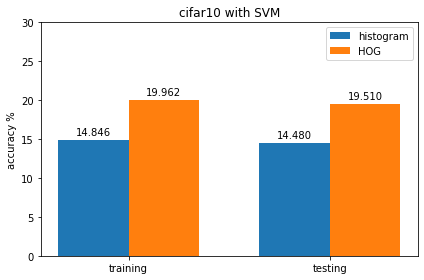

In [11]:
import numpy as np

labels = ['training', 'testing']
men_means = [acc_hist_train, acc_hist_test]
women_means = [acc_hog_train, acc_hog_test]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='histogram')
rects2 = ax.bar(x + width/2, women_means, width, label='HOG')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy %')
ax.set_title('cifar10 with SVM')
ax.set_ylim(0,30)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()